--- STEP 1: LOADING 'dataset.xlsx' ---
>> Success: Loaded 'dataset.xlsx' as Excel.
>> Total Respondents: 41
>> Groups Found: ['Tourism officer' 'NGO Staff' 'NGO staff']

       STATISTICAL ANALYSIS REPORT

[OBJECTIVE 1: Demographics]
Group
Tourism officer    20
NGO Staff          20
NGO staff           1
Name: count, dtype: int64

Sex Distribution:
Sex:
Female    21
Male      20
Name: count, dtype: int64

[OBJECTIVE 2: Roles of NGOs (Means)]
                 Role_Landslides  Role_Floods  Role_Earthquakes
Group                                                          
NGO Staff                   3.45         3.53              3.51
NGO staff                   4.00         4.00              4.00
Tourism officer             3.22         3.14              3.15

[OBJECTIVE 3: Influence on Tourism (Means)]
                 Inf_Return  Inf_Image  Inf_Rehab
Group                                            
NGO Staff              3.54       3.58       3.52
NGO staff              4.00       4.00 

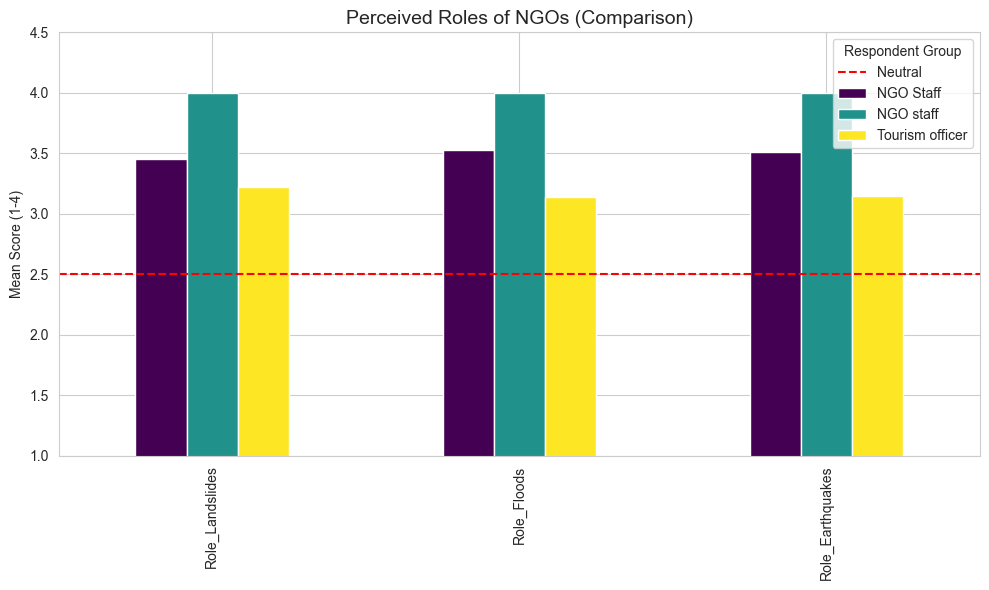

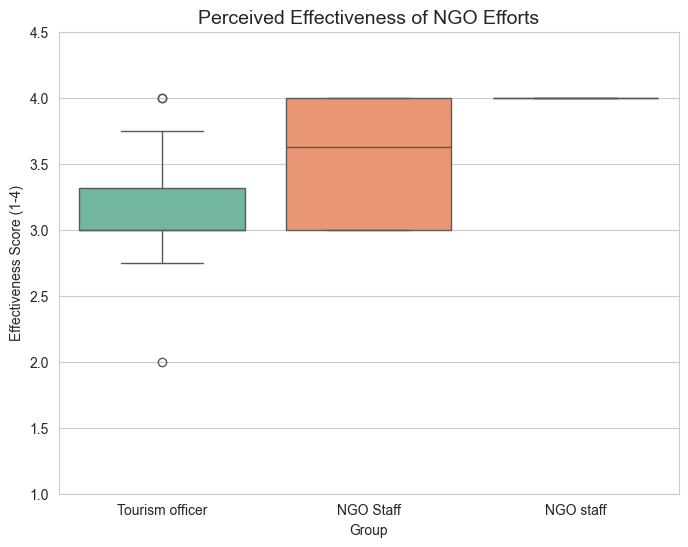

Analysis Complete.


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, ttest_ind
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# ==========================================
# 1. LOAD THE DATASET (EXCEL MODE)
# ==========================================
filename = 'dataset.xlsx'

print(f"--- STEP 1: LOADING '{filename}' ---")

try:
    # FORCE EXCEL READ
    df = pd.read_excel(filename, engine='openpyxl')
    print(f">> Success: Loaded '{filename}' as Excel.")
    print(f">> Total Respondents: {len(df)}")
except Exception as e:
    print(f"CRITICAL ERROR: Could not load '{filename}'.")
    print(f"Details: {e}")
    # Stop execution if loading fails
    df = pd.DataFrame()

if not df.empty:
    # ==========================================
    # 2. DATA CLEANING & SCORING
    # ==========================================
    
    # Standardize columns
    df.columns = df.columns.astype(str).str.strip()

    # Define Likert Scale Map (4-Point)
    likert_map = {
        'Strongly agree': 4, 'Strongly Agree': 4,
        'Agree': 3, 'agree': 3,
        'Disagree': 2,
        'Strongly disagree': 1, 'Strongly Disagree': 1,
        'Very aware': 4, 'Very Aware': 4,
        'Moderately aware': 3, 'Moderately Aware': 3,
        'Slightly aware': 2, 'Slightly Aware': 2,
        'Not aware at all': 1, 'not aware at all': 1,
        'N/A': np.nan, 'None': np.nan, 'nan': np.nan
    }

    def score_val(x):
        if isinstance(x, (int, float)): return x
        return likert_map.get(str(x).strip(), np.nan)

    # Exclude Demographics
    demo_cols = ['Timestamp', 'Please select your respondent type:', 'Name (Optional):', 'Sex:', 
                 'Educational Attainment:', 'Occupation:', 'Length of Residency in Baguio']

    # Apply Scoring to Non-Demo Columns
    score_cols = [c for c in df.columns if c not in demo_cols]
    for col in score_cols:
        df[col] = df[col].apply(score_val)

    # --- Create Group Column ---
    # Standardize the grouping variable
    if 'Please select your respondent type:' in df.columns:
        df['Group'] = df['Please select your respondent type:']
    else:
        df['Group'] = 'Unknown'

    print(f">> Groups Found: {df['Group'].unique()}")

    # ==========================================
    # 3. COMPUTE VARIABLES (OBJECTIVES 2-4)
    # ==========================================
    
    def compute_mean(dataframe, keyword):
        cols = [c for c in dataframe.columns if keyword in c]
        if cols:
            return dataframe[cols].mean(axis=1)
        return pd.Series([np.nan] * len(dataframe))

    # Objective 2: Roles
    df['Role_Landslides'] = compute_mean(df, '2.1')
    df['Role_Floods'] = compute_mean(df, '2.2')
    df['Role_Earthquakes'] = compute_mean(df, '2.3')

    # Objective 3: Influence
    df['Inf_Return'] = compute_mean(df, '3.1')
    df['Inf_Image'] = compute_mean(df, '3.2')
    df['Inf_Rehab'] = compute_mean(df, '3.3')

    # Objective 4: Effectiveness
    df['Effectiveness'] = compute_mean(df, '4.')
    # Fallback: If Section 4 is missing, use average of Influence (Section 3)
    if df['Effectiveness'].isna().all():
        print(">> Note: Section 4 not found. Using Section 3 average as proxy for Effectiveness.")
        df['Effectiveness'] = df[['Inf_Return', 'Inf_Image', 'Inf_Rehab']].mean(axis=1)

    # ==========================================
    # 4. STATISTICAL REPORT
    # ==========================================
    print("\n" + "="*50)
    print("       STATISTICAL ANALYSIS REPORT")
    print("="*50)

    # --- Obj 1: Demographics ---
    print("\n[OBJECTIVE 1: Demographics]")
    print(df['Group'].value_counts())
    if 'Sex:' in df.columns:
        print("\nSex Distribution:")
        print(df['Sex:'].value_counts())

    # --- Obj 2: Roles (Means) ---
    print("\n[OBJECTIVE 2: Roles of NGOs (Means)]")
    roles = df.groupby('Group')[['Role_Landslides', 'Role_Floods', 'Role_Earthquakes']].mean()
    print(roles.round(3))

    # --- Obj 3: Influence (Means) ---
    print("\n[OBJECTIVE 3: Influence on Tourism (Means)]")
    inf = df.groupby('Group')[['Inf_Return', 'Inf_Image', 'Inf_Rehab']].mean()
    print(inf.round(3))

    # --- Obj 4: Effectiveness (Means) ---
    print("\n[OBJECTIVE 4: Perceived Effectiveness]")
    eff = df.groupby('Group')['Effectiveness'].agg(['mean', 'std', 'count'])
    print(eff.round(3))

    # --- Obj 5: Significant Difference (T-Test / ANOVA) ---
    print("\n[OBJECTIVE 5: Comparison of Perceptions]")
    
    unique_groups = df['Group'].dropna().unique()
    
    if len(unique_groups) >= 2:
        # Prepare data arrays
        groups_data = [df[df['Group'] == g]['Effectiveness'].dropna() for g in unique_groups]
        
        # Run ANOVA
        f_stat, p_val = f_oneway(*groups_data)
        
        print(f"Groups Compared: {unique_groups}")
        print(f"Test Used:       One-Way ANOVA")
        print(f"F-Statistic:     {f_stat:.4f}")
        print(f"P-Value:         {p_val:.4e}")
        
        if p_val < 0.05:
            print("Conclusion:      SIGNIFICANT DIFFERENCE exists between groups.")
        else:
            print("Conclusion:      NO SIGNIFICANT DIFFERENCE (Perceptions are similar).")
            
    else:
        print("Note: Only 1 group found. Cannot perform comparison test (T-Test/ANOVA).")

    # ==========================================
    # 5. VISUALIZATIONS
    # ==========================================
    print("\nGenerating Plots...")

    # Plot 1: Roles Bar Chart
    if not roles.empty:
        roles.T.plot(kind='bar', figsize=(10, 6), colormap='viridis')
        plt.title('Perceived Roles of NGOs (Comparison)', fontsize=14)
        plt.ylabel('Mean Score (1-4)')
        plt.ylim(1, 4.5)
        plt.axhline(2.5, color='red', linestyle='--', label='Neutral')
        plt.legend(title='Respondent Group')
        plt.tight_layout()
        plt.show()

    # Plot 2: Effectiveness Boxplot
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='Group', y='Effectiveness', data=df, palette='Set2')
    plt.title('Perceived Effectiveness of NGO Efforts', fontsize=14)
    plt.ylabel('Effectiveness Score (1-4)')
    plt.ylim(1, 4.5)
    plt.show()

    print("Analysis Complete.")

else:
    print("Script halted due to loading error.")